In [162]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/



### ***Below is a buy side trading strategy that has been tested on historical data.*** 
### ***(Period: last 4 years, Interval: 1 day, Script: All constituents of NIFTY50)***

### ***Idea behind the strategy:***

>#### ***This logic is applicable for all the constituents of NIFTY50:***
>#### ***a. This is mean reversion logic with assumption that NIFTY50 are quality stocks. If a stock falls continuously for 4 days from a specific level of standard deviation then they can be bought, and every rise they will be squared off. The logic is based on using Bollinger band indicator for calculations.***
>#### ***b. Long Entry Criteria: if ((sma-bb_width * std)>Close_price) then take long position***
>#### ***c. Long Exit Criteria: exit the long postion when ((sma+bb_width * std)<Close_price)***
#### ***Definition of the parameters:***
>#### ***a.  bb_width is the number of std distance from sma.*** 
>#### ***b. (sma-bb_width * std) becomes the lower level***
>#### ***c. (sma+bb_width * std) becomes the upper level***

# Algorithm

In [163]:
'''
import the necessary libraries
'''
import pandas as pd
import numpy as np
import datetime
import yfinance as yf

In [164]:
'''
# Function to backtest any strategy by using the following parameters:        
    #Dataframe, 
    #strategy_type(long/short),entry_criteria,exit_criteria
    #positional_field ,price_field(example Close price),stoploss_pct(stop loss pct),target_pct,only_profit(should wait for trade to be in profit True/False)
'''
def backtest_strategy_stoploss(df, strategy_type,lst_entry_criteria,lst_exit_criteria, positional_field,price_field,stoploss_pct,target_pct,only_profit):
    df['buy_price']=0.0000
    df['sell_price']=0.0000
  
    df['buy_time']=None
    df['sell_time']=None
    exit_reason_field=positional_field+'_exit_flag'
    df[positional_field]=0
    df[exit_reason_field]=''
    pos=0

    last_buy_price=0.00
    last_sell_price=0.00
    
    for d in range(0,len(df)):
        entry_flag=lst_entry_criteria[d]
        exit_flag=lst_exit_criteria[d]
        curr_price=df[price_field].iloc[d]
        curr_time=df.index[d]
        stoploss_exit=False
        target_exit=False
        only_profit_exit=False
        exit_reason=''
        
        if stoploss_pct!=0:
            if (strategy_type=='long')&(last_buy_price>0):
                if ((curr_price-last_buy_price)*100/last_buy_price)<stoploss_pct:
                    stoploss_exit=True
                    exit_reason='SLM'
            elif (strategy_type=='short')&(last_sell_price>0):    
                if ((last_sell_price-curr_price)*100/curr_price)<stoploss_pct:
                    stoploss_exit=True
                    exit_reason='SLM'
                    
        if target_pct!=0:
            if (strategy_type=='long')&(last_buy_price>0):
                if ((curr_price-last_buy_price)*100/last_buy_price)>target_pct:
                    target_exit=True
                    exit_reason='TRM'
            elif (strategy_type=='short')&(last_sell_price>0):    
                if ((last_sell_price-curr_price)*100/curr_price)>target_pct:
                    target_exit=True
                    exit_reason='TRM'

        if only_profit==True:
            if (strategy_type=='long')&(last_buy_price>0):
                if ((curr_price-last_buy_price)*100/last_buy_price)>0:
                    only_profit_exit=True
            elif (strategy_type=='short')&(last_sell_price>0):    
                if ((last_sell_price-curr_price)*100/curr_price)>0:
                    only_profit_exit=True
        else:
            only_profit_exit=True

        if exit_flag:
            exit_reason='ECM'
            
        if entry_flag&(pos==0) :
             if strategy_type=='long':
                df['buy_price'].iat[d]= df[price_field].iloc[d]
                last_buy_price=df[price_field].iloc[d]
                df[positional_field].iat[d]=1
             elif strategy_type=='short':
                df['sell_price'].iat[d]= df[price_field].iloc[d]
                last_sell_price=df[price_field].iloc[d]
                df[positional_field].iat[d]=-1
             pos=1
        elif (exit_flag|stoploss_exit|target_exit)& only_profit_exit & (pos==1) :
             df[exit_reason_field].iat[d]=exit_reason
             
             if strategy_type=='long':
                df['sell_price'].iat[d]= df[price_field].iloc[d]
                last_sell_price=df[price_field].iloc[d]
                df[positional_field].iat[d]=-1
             elif strategy_type=='short':
                df['buy_price'].iat[d]= df[price_field].iloc[d]
                last_buy_price=df[price_field].iloc[d]
                df[positional_field].iat[d]=1
             pos=0

    df_temp=df[df[positional_field]!=0].copy()
    
    df_temp['buy_time']=df_temp.index
    df_temp['sell_time']=df_temp.index

    df_buy=df_temp[df_temp.buy_price>0][['buy_price','buy_time']]
    df_buy.reset_index(drop=True,inplace=True)
    
    df_sell=df_temp[df_temp.sell_price>0][['sell_price','sell_time']]
    df_sell.reset_index(drop=True,inplace=True)
    
    long= pd.concat([df_buy,df_sell],axis=1,copy=True)
    '''
    long['sell_price_curr']=long['sell_price']
    if len(long)>0:
        if ~(long['sell_price'].iloc[-1]>0):
            long['sell_price_curr'].iat[-1]=curr_price
    '''      
    #long["sell_price_curr"]=np.where(long["sell_price"].astype(str)=='nan',long["sell_price"])
    long["returns"]=(long["sell_price"]-long["buy_price"])*100/long["buy_price"]
    long['cum_returns']=(long['sell_price']/long['buy_price']).cumprod()
    long['investment_period']=(long['sell_time']-long['buy_time'])
    
    short= pd.concat([df_buy,df_sell],axis=1,copy=True)
    
    if len(short)>0:
        if ~(short['buy_price'].iloc[-1]>0):
            short['buy_price'].iat[-1]=curr_price
            short['buy_time'].iat[-1]=curr_time
            
    short["returns"]=(short["sell_price"]-short["buy_price"])*100/short["buy_price"]
    short['cum_returns']=(short['sell_price']/short['buy_price']).cumprod()
    short['investment_period']=(short['buy_time']-short['sell_time'])
    
    if strategy_type=='long':
        return df,long
    else:
        return df,short



In [165]:
'''
# Function to generate backtest reports
'''
def backtest_reports_local(df_summary,lot_size,trx_charge):
    return round(df_summary['returns'].sum()-(df_summary['buy_price']*lot_size*trx_charge/100).sum(),2),len(df_summary)



In [166]:
'''
Function to fetch data for the algorithm 
'''
def fetch_data_yf(script,lookback_period,interval='1d') :
    todate=datetime.datetime.now().date()
    fromdate=todate-datetime.timedelta(days=lookback_period)
        
    df = yf.download(str(script), start=fromdate, end=todate,interval=interval)
    df['Close']=df['Adj Close']
    #df["Date"]=pd.to_datetime(df.Date)
    #print(script,str(script)[0:1])
    if str(script)[0:1]!='^':
        df=df[df['Volume']>0].copy()

    return df


In [167]:

'''
Function to write buy/sell signals for the algo
'''

def bb(df_temp,price_field,strategy_type):
    bb_width_entry=1.7
    bb_width_exit=1.7
    
    sma_lookback=25
    df_temp['sma']=df_temp[price_field].rolling(sma_lookback).mean()
    df_temp['std']=df_temp[price_field].rolling(sma_lookback).std()
    df_temp['lower_bb']=(df_temp['sma']-bb_width_entry*df_temp['std'])
    df_temp['upper_bb']=(df_temp['sma']+bb_width_exit*df_temp['std'])

    if strategy_type=='long':
        boll_entry=((df_temp['sma']-bb_width_entry*df_temp['std'])>df_temp[price_field])#&(df_temp[price_field].shift(1)>df_temp[price_field].shift(0))
        boll_entry=boll_entry&boll_entry.shift(1)&boll_entry.shift(2)&boll_entry.shift(3)

        boll_exit=((df_temp['sma']+bb_width_exit*df_temp['std'])<df_temp[price_field])
        boll_exit=boll_exit&boll_exit.shift(1)&boll_exit.shift(2)
        

        df_temp['long_entry']=boll_entry
        df_temp['long_exit']=boll_exit

    if strategy_type=='short':
        boll_exit=((df_temp['sma']-bb_width_exit*df_temp['std'])>df_temp[price_field])&(df_temp['ema_signal']==1)
        boll_entry=((df_temp['sma']+bb_width_entry*df_temp['std'])<df_temp[price_field])&(df_temp['ema_signal']==-1)

        df_temp['short_entry']=boll_entry
        df_temp['short_exit']=boll_exit

    return df_temp,boll_entry,boll_exit

In [168]:
'''
main Function 
'''

def bb_backtest_positional(df,script,lot_size,trx_charges,slippages):

    summary_min_grand=pd.DataFrame()

    for strat_type in ['long']:
        df_temp=df.copy()
        price_field='Close'
        
        strategy_type=strat_type
        df_temp,boll_entry,boll_exit=bb(df_temp,price_field,strategy_type)

        if strategy_type=='long':
            final_entry=boll_entry
            final_exit=boll_exit
        elif strategy_type=='short':    
            final_entry=boll_entry
            final_exit=boll_exit
        
        positional_field='pos_bb'
        price_field='Close'
        stoploss_pct=-28
        target_pct=28
        only_profit=True
        
        df_temp,summary_min=backtest_strategy_stoploss(df_temp, strategy_type,list(final_entry),list(final_exit), positional_field,price_field,stoploss_pct,target_pct,only_profit)
        df_temp['Close_pct_change']=df_temp['Close'].pct_change()*100
        '''
        df_temp['1day_pct_change']=df_temp['Close_pct_change'].shift(-1)
        df_temp['2day_pct_change']=df_temp['Close_pct_change'].shift(-2)
        df_temp['3day_pct_change']=df_temp['Close_pct_change'].shift(-3)
        df_temp['4day_pct_change']=df_temp['Close_pct_change'].shift(-4)
        '''
        df_temp['script']=script
        df_temp2=df_temp[df_temp.pos_bb==1]
        summary_min['returns_abs']=(summary_min['sell_price']-summary_min['buy_price'])*lot_size
        summary_min['returns_abs']=summary_min['returns_abs']-trx_charges
        summary_min['strat_type']=strat_type
        summary_min['script']=script

        print(script,' buy_time ',summary_min['buy_time'].iloc[-1],' sell_time ',summary_min['sell_time'].iloc[-1])
        summary_min_grand=summary_min_grand.append(summary_min)
    return summary_min_grand,df_temp2,df_temp

In [169]:
'''
Defining the variables
'''
lst_nift50=['ADANIPORTS.NS',	'ASIANPAINT.NS',	'AXISBANK.NS',	'BAJAJ-AUTO.NS',	'BAJFINANCE.NS',	'BAJAJFINSV.NS',	'BHARTIARTL.NS',	'BRITANNIA.NS',	'CIPLA.NS',	'DIVISLAB.NS',	'DRREDDY.NS',	'GRASIM.NS',	'HCLTECH.NS',	'HDFCBANK.NS',	'HDFCLIFE.NS',	'HEROMOTOCO.NS',	'HINDALCO.NS',	'HDFC.NS',	'ICICIBANK.NS',	'INDUSINDBK.NS',	'INFY.NS',	'JSWSTEEL.NS',	'KOTAKBANK.NS',	'LT.NS',	'M&M.NS',	'MARUTI.NS',	'NESTLEIND.NS',	'RELIANCE.NS',	'SBILIFE.NS',	'SBIN.NS',	'SUNPHARMA.NS',	'TCS.NS',	'TATAMOTORS.NS',	'TATASTEEL.NS',	'TECHM.NS',	'TITAN.NS',	'ULTRACEMCO.NS',	'WIPRO.NS']
lst_nift50=['ADANIPORTS.NS']
#lst_nift50=['ADANIPORTS.NS',	'ASIANPAINT.NS',	'AXISBANK.NS',	'BAJAJ-AUTO.NS']
print('Script   Returns in pct')
total_returns=0
tot_trx_count=0
count=0


Script   Returns in pct


In [170]:
'''
invoking the main Function 
'''
df_temp_grand=pd.DataFrame()

summary_min_grand_all=pd.DataFrame()
for script in lst_nift50:
    lookback_period=365*3
    lot_size=1
    trx_charges=0
    bid_ask_parity=0
    slippages=bid_ask_parity
    try:
        df= fetch_data_yf(script,lookback_period,interval='1d') 
        #df= fetch_data_yf(script,lookback_period,interval='1wk') 
        
        summary_min_grand,df_temp,df_temp_all=bb_backtest_positional(df,script,lot_size,trx_charges,slippages)
        returns_pct,trx_count=backtest_reports_local(summary_min_grand,1,0)
        total_returns=total_returns+returns_pct
        tot_trx_count=tot_trx_count+trx_count
        summary_min_grand_all=summary_min_grand_all.append(summary_min_grand)
        df_temp_grand=df_temp_grand.append(df_temp)

        count=count+1
        print(script,'    ',returns_pct)
    except :
        pass

            

[*********************100%***********************]  1 of 1 completed
ADANIPORTS.NS  buy_time  2022-05-13 00:00:00  sell_time  NaT
ADANIPORTS.NS      44.94


In [171]:
summary_min_grand_all.reset_index(drop=True,inplace=True)

In [172]:
summary_min_grand_all['buy_price']=np.round(summary_min_grand_all['buy_price'],2)
summary_min_grand_all['sell_price']=np.round(summary_min_grand_all['sell_price'],2)
summary_min_grand_all['returns']=np.round(summary_min_grand_all['returns'],2)
summary_min_grand_all['returns_abs']=np.round(summary_min_grand_all['returns_abs'],2)

summary_min_grand_all.sort_values(by='buy_time')

,buy_price,buy_time,sell_price,sell_time,returns,cum_returns,investment_period,returns_abs,strat_type,script
0,367.19,2019-07-29,406.48,2019-09-24,10.70,1.106995,57 days,39.29,long,ADANIPORTS.NS
1,359.14,2019-11-18,384.82,2020-01-09,7.15,1.186163,52 days,25.68,long,ADANIPORTS.NS
2,341.11,2020-03-03,345.68,2020-08-14,1.34,1.202035,164 days,4.56,long,ADANIPORTS.NS
3,323.88,2020-09-25,407.30,2020-11-26,25.76,1.511619,62 days,83.42,long,ADANIPORTS.NS
4,705.90,2022-05-13,NaN,NaT,NaN,NaN,NaT,NaN,long,ADANIPORTS.NS


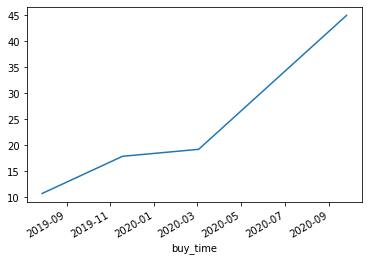

In [173]:
summary_min_grand_all.returns.sum()
summary_min_grand_all.index=summary_min_grand_all.buy_time
summary_min_grand_all.sort_index(inplace=True)
summary_min_grand_all.investment_period=summary_min_grand_all.investment_period.dt.days
summary_min_grand_all['pct_returns_per_day']=summary_min_grand_all.returns/summary_min_grand_all.investment_period

summary_min_grand_all['returns_cumsum']=summary_min_grand_all['returns'].cumsum()
summary_min_grand_all['returns_cumsum'].plot()
#print(summary_min_grand_all.returns.plot)

In [174]:
summary_min_grand_all.sort_index()

,buy_price,buy_time,sell_price,sell_time,returns,cum_returns,investment_period,returns_abs,strat_type,script,pct_returns_per_day,returns_cumsum
buy_time,,,,,,,,,,,,
2019-07-29,367.19,2019-07-29,406.48,2019-09-24,10.70,1.106995,57.0,39.29,long,ADANIPORTS.NS,0.187719,10.70
2019-11-18,359.14,2019-11-18,384.82,2020-01-09,7.15,1.186163,52.0,25.68,long,ADANIPORTS.NS,0.137500,17.85
2020-03-03,341.11,2020-03-03,345.68,2020-08-14,1.34,1.202035,164.0,4.56,long,ADANIPORTS.NS,0.008171,19.19
2020-09-25,323.88,2020-09-25,407.30,2020-11-26,25.76,1.511619,62.0,83.42,long,ADANIPORTS.NS,0.415484,44.95
2022-05-13,705.90,2022-05-13,NaN,NaT,NaN,NaN,NaN,NaN,long,ADANIPORTS.NS,NaN,NaN


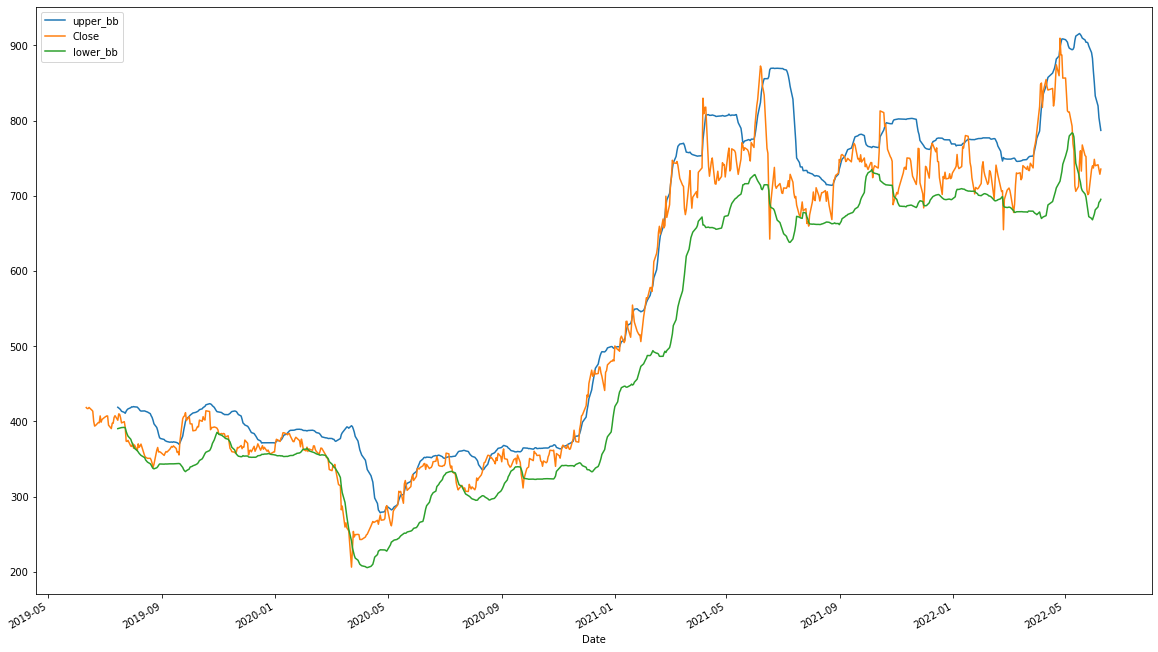

In [175]:
#df_temp_all['long_signal']=np.where(df_temp_all['long_entry']=='true',1,0)+np.where(df_temp_all['long_exit']=='true',-1,0)
#df_temp_all[['upper_bb','Close','lower_bb','long_signal']].plot(y=['upper_bb','Close','lower_bb','long_signal'],secondary_y='long_signal')
df_temp_all[['upper_bb','Close','lower_bb']].plot(y=['upper_bb','Close','lower_bb'],figsize=(20,12))

#df_temp_all[['Close','long_entry', 'long_exit', 'buy_price','sell_price']]